# Home credit default risk
## All the information used in this kernel has been inspired by this amazing kernel: [here](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/notebook) 
## so grateful for all the information
### If you have any suggestions, critics or feedback, feel free to leave me a heads up here...

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns #for better and easier plots
%matplotlib inline

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['installments_payments.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'bureau.csv', 'application_test.csv', 'application_train.csv', 'POS_CASH_balance.csv', 'sample_submission.csv', 'previous_application.csv']


* Loading the application train, this is gonna be the base on which we are going to add more information from other datasets that has been provided to us.

In [2]:
app_df = pd.read_csv("../input/application_train.csv")

* checking the shape of the data
* calling head to see the first entries

In [3]:
app_df.shape

(307511, 122)

In [4]:
app_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


* Loading the testing set, checking the shape as well

In [5]:
app_test_df = pd.read_csv("../input/application_test.csv")

In [6]:
app_test_df.shape

(48744, 121)

#### Implementing a function to check for null values and plot a countplot

In [7]:
#let's create a function to check for null values, calculate the percentage relative to the total size
#only shows the null values present in the dataset
def missing_values_calculate(trainset): 
    nulldata = (trainset.isnull().sum() / len(trainset)) * 100
    nulldata = nulldata.drop(nulldata[nulldata == 0].index).sort_values(ascending=False)
    ratio_missing_data = pd.DataFrame({'Ratio' : abs(nulldata)})
    return ratio_missing_data.head(30)

In [8]:
def remove_missing_columns(train, test, threshold = 90): #threshold is set by default at 90%
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [9]:
missing_values_calculate(app_df)

,Ratio
COMMONAREA_MEDI,69.872297
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
NONLIVINGAPARTMENTS_AVG,69.432963
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MEDI,68.354953
LIVINGAPARTMENTS_MODE,68.354953


#### A bunch of null values that need to be imputed, gonna address it soon

In [10]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


* We have 3 different types in our dataset(float64, int64, object), Gonna implement a function that reduce the amount of memory used.

In [11]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#### looking for outliers or some anomalies...

In [12]:
app_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


> The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [13]:
(app_df['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

* no issues here, the max and min are reasonable... 
* what about days employed

In [14]:
app_df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

* as can be seen, the max value is not reasonable at all, here we have an outlier that might be a mistake when the data was created

In [15]:
app_df[app_df['DAYS_EMPLOYED'] >= 300000].describe() 

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,55374.000000,55374.000000,55374.000000,5.537400e+04,5.537400e+04,55374.000000,5.535200e+04,55374.000000,55374.000000,55374.0,55374.000000,55374.000000,10169.000000,55374.0,55374.0,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.0,55374.0,55374.000000,55374.0,55374.0,12857.000000,55218.000000,44305.000000,26649.000000,22444.000000,27708.000000,18266.000000,16396.000000,25261.000000,26896.000000,27211.000000,...,26896.000000,27211.000000,17530.000000,21926.000000,17239.000000,26937.000000,16620.000000,24192.000000,27996.000000,55202.000000,55202.000000,55202.000000,55202.000000,55374.000000,55374.0,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.0,55374.0,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.000000,55374.0,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000
mean,278480.472424,0.053996,0.046123,1.363956e+05,5.426899e+05,23904.303202,4.882973e+05,0.020749,-21810.009373,365243.0,-6582.930978,-3875.560155,13.090766,1.0,0.0,0.000018,0.999314,0.296475,0.025842,1.697981,2.088200,2.068805,11.426482,0.005598,0.0,0.0,0.025373,0.0,0.0,0.692897,0.506436,0.558835,0.113597,0.088215,0.978846,0.751053,0.042555,0.076062,0.150639,0.221265,...,0.150155,0.220840,0.225905,0.065475,0.097821,0.105534,0.008168,0.026252,0.099022,1.451759,0.159233,1.435328,0.110920,-925.613447,0.0,0.469408,0.000090,0.009932,0.449525,0.000126,0.010167,0.000722,0.000018,0.0,0.0,0.000253,0.000217,0.000144,0.000831,0.000018,0.000361,0.000072,0.000018,0.0,0.005554,0.007105,0.035694,0.200562,0.291379,2.099893
std,102674.560705,0.226013,0.275873,7.666086e+04,3.784991e+05,13308.379238,3.471510e+05,0.013635,2008.084123,0.0,4201.502789,1117.887551,11.544117,0.0,0.0,0.004250,0.026187,0.456707,0.158667,0.558580,0.491916,0.483858,3.025820,0.074613,0.0,0.0,0.157256,0.0,0.0,0.161788,0.195964,0.181897,0.103428,0.082774,0.049472,0.107138,0.070777,0.131272,0.097503,0.140454,...,0.097787,0.140801,0.157958,0.076708,0.087954,0.108309,0.045369,0.064621,0.101559,2.405392,0.467458,2.385691,0.380401,823.523395,0.0,0.499068,0.009502,0.099166,0.497450,0.011243,0.100320,0.026867,0.004250,0.0,0.0,0.015899,0.014720,0.012019,0.028810,0.004250,0.019001,0.008499,0.004250,0.0,0.077901,0.109551,0.212983,0.746708,0.640675,2.042700
min,100011.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.500000e+04,0.000290,-25229.000000,365243.0,-24672.0

* well, we have 55374 values where our 'days employed' column is more than 300000, which is not a correct value. However, with such a high amount of entries showing this issue, one good approach would be to change the values to NAN and then, afterwards, impute those values with a median value

In [16]:
app_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) #imputing the testing set as well...

**Taking a look at the pearson's correlation using the .corr() method**

In [17]:
corr = app_df.corr()['TARGET'].sort_values(ascending=False)

corr.head(10) #looking at the first 10 positively correlated

TARGET                         1.000000
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
Name: TARGET, dtype: float64

In [18]:
corr.tail(10).sort_values() #now looking at the first 10 negatively correlated

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
Name: TARGET, dtype: float64

> DAYS_BIRTH is the age in days of the client at the time of the loan in negative days. Meaning, the older the client gets, it is less likely that the loan defaults

#### gonna plot the KDE distribution relative to target, trying to show the relationship described above

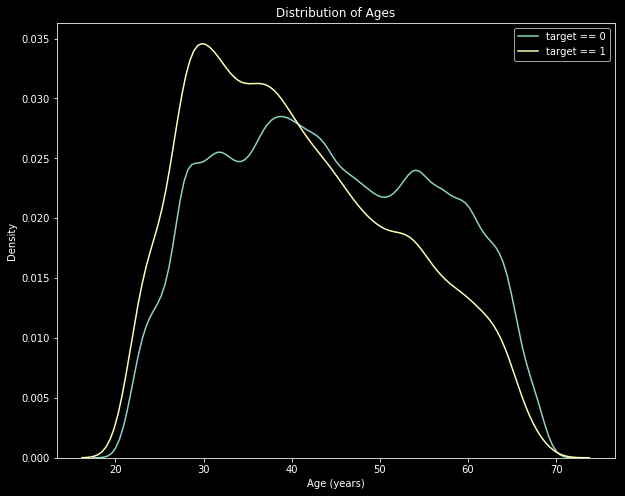

In [19]:
plt.style.use('dark_background')
plt.figure(figsize = (10, 8))
# KDE plot of loans that were repaid on time
sns.kdeplot(app_df.loc[app_df['TARGET'] == 0, 'DAYS_BIRTH'] * -1/ 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_df.loc[app_df['TARGET'] == 1, 'DAYS_BIRTH'] * -1/ 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

##### it's clear that the older the client gets, it's more likely that he is gonna pay the credit
* the higher amount of credit default can be found within ages 20-25

### I would like to plot a heat map with the top positive correlation feature(DAYS BIRTH) and all the top 3 negativaly correlated(all External Sources)

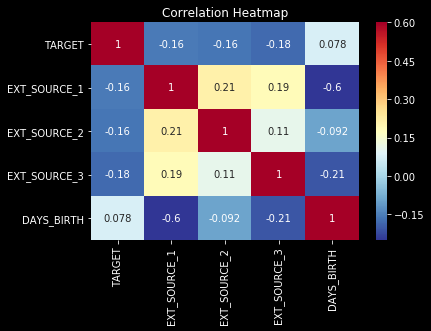

In [20]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

** As we have plotted the KDE for days birth, gonna do the same for all the external sources features **

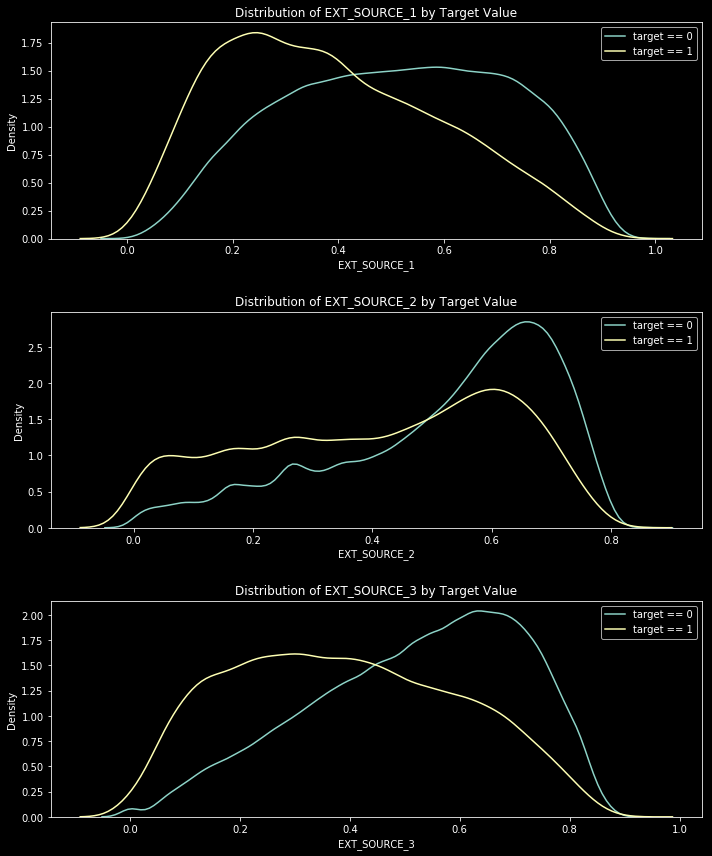

In [21]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_df.loc[app_df['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_df.loc[app_df['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

***

## Before diving into feature engineering and creating features that helps our models learn more from our data, I am gonna implement pipelines and a function to help us test our first models and see how they perform.

In [22]:
app_df.shape

(307511, 122)

* We have created a validation dataset in order to test our models, now let's take a look at the shape before implementing the functions to help us test our models

In [23]:
#let's use the Imputer to fill the NAN values with the median value
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Imputer, RobustScaler

#imputing all NaN value
pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), 
        #('scale', MinMaxScaler(feature_range = (0, 1))),
        ('robustScaler', RobustScaler()),
])

In [24]:
from sklearn.metrics import precision_score, recall_score, accuracy_score,confusion_matrix,classification_report,f1_score, roc_auc_score
import time #implementing in this function the time spent on training the model
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,cross_val_score,train_test_split, KFold
import gc

nfolds = 5
folds = KFold(n_splits=nfolds, shuffle=True,random_state=42)


#Generic function for making a classification model and accessing performance:
def classification_model(train, train_labels, test_set, pipeline, params={}, fold=folds, plot_confusion_matrix=False, model=None, GridSearch=False, plot_features_importances=False):
    
    time_start = time.perf_counter() #start counting the time
    #creating our validation set out of the training set and labels provided
    X_train, x_val, y_train, y_val = train_test_split(train, train_labels, test_size=0.1, random_state=42)
    X_train = pipeline.fit_transform(X_train) #fiting and transforming the dataset using the pipeline provided
    x_val = pipeline.fit_transform(x_val)
    
    test_sub = np.zeros(test_set.shape[0])
    test_set = pipeline.fit_transform(test_set)
    
    predict_val = np.zeros(train.shape[0])
    score = {}
    
    if model != None: grid_model = GridSearchCV(model, params,verbose=1, cv=3) #initializing the grid search model

    if GridSearch:
        grid_model.fit(X_train, y_train)
        score_grid = grid_model.best_score_
        
        #predicting using the model that has been trained above
        
        predict_val = grid_model.predict(x_val)
        score['Accuracy'] = (accuracy_score(y_val, predict_val))
        score['Precision'] = (precision_score(y_val, predict_val))
        score['F1 score'] = (f1_score(y_val, predict_val))
        score['ROC AUC'] = (roc_auc_score(y_val, predict_val))
        
        print("Model Report")

        print("Accuracy: "+ str(score["Accuracy"]))
        print("Precision: "+ str(score["Precision"]))
        print("F1 score: "+ str(score["F1 score"]))
        print("ROC AUC: "+ str(score["ROC AUC"]))
        print('\n')
        
        print("         -------Classification Report----------")
        print(classification_report(y_val, predict_val))
    
        test_sub = grid_model.predict(test_set) 
        
    else:
        model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)

        for n, (index, val_index) in enumerate(folds.split(train)):
            
            print('Starting Fold number: %d' %n)
            X, X_val = train.values[index], train.values[val_index]
            Y, Y_val = train_labels[index], train_labels[val_index]
            X = pipeline.fit_transform(X)
            X_val = pipeline.fit_transform(X_val)
            
            model.fit(X, Y, 
                    eval_set=[(X, Y), (X_val, Y_val)],
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_val)
            test_temp = model.predict(test_set, num_iteration=model.best_iteration_)
            test_sub += test_temp               
            if score == {}:
                score['Accuracy'] = accuracy_score(Y_val, y_pred_valid)
                score['Precision']= precision_score(Y_val, y_pred_valid)
                score['F1 score'] = f1_score(Y_val, y_pred_valid)
                score['ROC AUC'] = roc_auc_score(Y_val, y_pred_valid)
            else:
                score['Accuracy'] += accuracy_score(Y_val, y_pred_valid)
                score['Precision'] += precision_score(Y_val, y_pred_valid)
                score['F1 score'] += f1_score(Y_val, y_pred_valid)
                score['ROC AUC'] += roc_auc_score(Y_val, y_pred_valid)
                        
        test_sub /= nfolds
                        
        print("Model Report")

        print("Accuracy(avg across folds): "+ str(score["Accuracy"]/nfolds))
        print("Precision(avg across folds): "+ str(score["Precision"]/nfolds))
        print("F1 score(avg across folds): "+ str(score["F1 score"]/nfolds))
        print("ROC AUC(avg across folds): "+ str(score["ROC AUC"]/nfolds))
        print('\n')

        
    #################### PLOTTING FEATURES IMPORTANCE ####################
    
    # Sort features according to importance
    if plot_features_importances:
        if GridSearch:
            # Extract feature importances
            feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': grid_model.best_estimator_.feature_importances_})
        else:
            feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': model.feature_importances_})
        
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()

        # Normalize the feature importances to add up to one
        feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(feature_importances.index[:15]))), 
                feature_importances['importance_normalized'].head(15), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
        ax.set_yticklabels(feature_importances['feature'].head(15))

        # Plot labeling
        plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    
    #################### PLOTTING CONFUSION MATRIX #######################
    
    if plot_confusion_matrix:
        fig, ax = plt.subplots(figsize=(8,8)) #setting the figure size and ax
        mtx = confusion_matrix(y_val, predict_val)
        sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  cbar=True, ax=ax) #create a heatmap with the values of our confusion matrix
        plt.ylabel('true label')
        plt.xlabel('predicted label')

    
    time_end = time.perf_counter() #end of counting the time
    
    total_time = time_end-time_start #total time spent during training and cross_validation
    
    print("Amount of time spent during training the model and cross validation: %4.3f seconds" % (total_time))
    # Clean up memory
    gc.enable()
    del model, X_train, x_val, y_train, y_val,score, total_time, time_end, time_start,predict_val,test_set
    gc.collect()
                        
    return test_sub

# Second Part - Improving our model -
## it was provided extra datasets with plenty of information that can be added to our training set, help us engineering some extra features and improve our model
### Gonna start loading bureau.csv, which contains information of previous loans of each client

In [25]:
bureau_df = pd.read_csv('../input/bureau.csv')#loading the dataset
bureau_df.shape #checking the shape of our dataset

(1716428, 17)

#### let's have an overall picture using .head()

In [26]:
bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


#### We have the ID's of each client, which is the SK_ID_CURR, and information like when the loan was taken, end date, is it overdue, days credit and so forth....so we have here a credit history

In [27]:
num_of_previous_credits = bureau_df.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'}) 
#grouping by the client's ID and counting the number of credits using the ID bureau. then,renaming the column to something more informative
num_of_previous_credits.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


** Nice, now we have the number of past credits each client have**
* let's add this information to our training dataset

In [28]:
app_df = app_df.merge(num_of_previous_credits, on = 'SK_ID_CURR', how = 'left')
app_df['previous_loan_counts'] = app_df['previous_loan_counts'].fillna(0) #filling all the clients that doesn't have past loans with 0

* Let's see the correlation with our target:

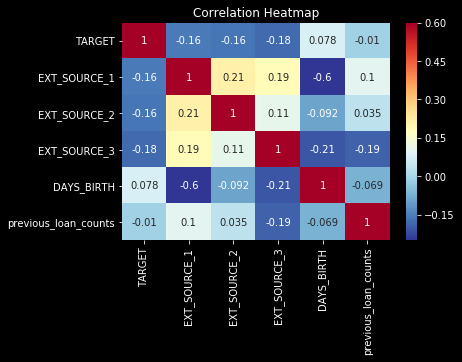

In [29]:
#getting only the relevant columns that we would like to see the correlation, in this case, getting previous columns plus the new feature
relevant_columns = app_df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'previous_loan_counts']]
corr = relevant_columns.corr()

# Heatmap of correlations
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

* The correlation is really low, and negatively correlated, the higher this value(more past loans), less likely to default(remember, past loans that have been paid)

## as it was used previously, the KDE plot is gonna also show the relationship between one variable and other variables. It's gonna be implemented a function to help us plot using different variables

In [30]:
## CREDITS TO WILL KOERSEHN ##
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
        
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    

**Now, let's plot the KDE correlation of each of the columns I used before and see what the KDE plot show us **

The correlation between EXT_SOURCE_1 and the TARGET is -0.1553
Median value for loan that was not repaid = 0.3617
Median value for loan that was repaid =     0.5175
The correlation between EXT_SOURCE_2 and the TARGET is -0.1605
Median value for loan that was not repaid = 0.4404
Median value for loan that was repaid =     0.5739
The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460
The correlation between DAYS_BIRTH and the TARGET is 0.0782
Median value for loan that was not repaid = -14282.0000
Median value for loan that was repaid =     -15877.0000
The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


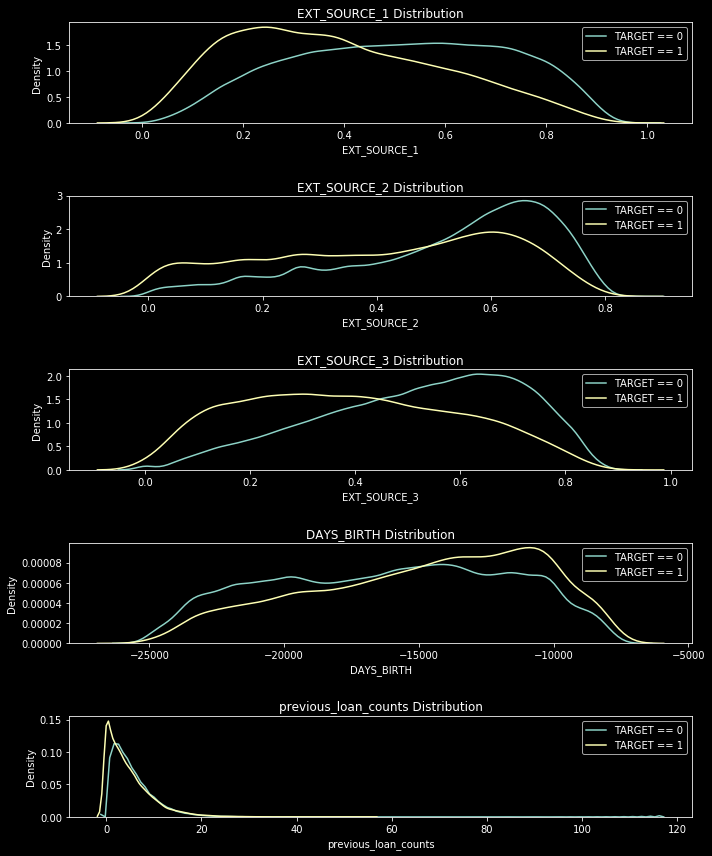

In [31]:
plt.figure(figsize = (10, 12))
for i,column in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'previous_loan_counts']):
    plt.subplot(5,1, i+1)
    kde_target(column, app_df)
plt.tight_layout(h_pad = 2.5)

#### I am repeating the KDE graphs for the other columns to a base for comparison
##### Unfortunately, tho, our new feature is not really helpful...

* gonna continue with feature engineering

***

* Creating a funtion that gets a dataframe, column name and dataframe name, groups by the column name and aggregate using mean, count,min, max and sum.

In [32]:
## CREDITS TO WILL KOERSEHN ##

def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [33]:
bureau_grouped = agg_numeric(bureau_df.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name= 'bureau_df')
bureau_grouped.head()

,SK_ID_CURR,bureau_df_DAYS_CREDIT_count,bureau_df_DAYS_CREDIT_mean,bureau_df_DAYS_CREDIT_max,bureau_df_DAYS_CREDIT_min,bureau_df_DAYS_CREDIT_sum,bureau_df_CREDIT_DAY_OVERDUE_count,bureau_df_CREDIT_DAY_OVERDUE_mean,bureau_df_CREDIT_DAY_OVERDUE_max,bureau_df_CREDIT_DAY_OVERDUE_min,bureau_df_CREDIT_DAY_OVERDUE_sum,bureau_df_DAYS_CREDIT_ENDDATE_count,bureau_df_DAYS_CREDIT_ENDDATE_mean,bureau_df_DAYS_CREDIT_ENDDATE_max,bureau_df_DAYS_CREDIT_ENDDATE_min,bureau_df_DAYS_CREDIT_ENDDATE_sum,bureau_df_DAYS_ENDDATE_FACT_count,bureau_df_DAYS_ENDDATE_FACT_mean,bureau_df_DAYS_ENDDATE_FACT_max,bureau_df_DAYS_ENDDATE_FACT_min,bureau_df_DAYS_ENDDATE_FACT_sum,bureau_df_AMT_CREDIT_MAX_OVERDUE_count,bureau_df_AMT_CREDIT_MAX_OVERDUE_mean,bureau_df_AMT_CREDIT_MAX_OVERDUE_max,bureau_df_AMT_CREDIT_MAX_OVERDUE_min,bureau_df_AMT_CREDIT_MAX_OVERDUE_sum,bureau_df_CNT_CREDIT_PROLONG_count,bureau_df_CNT_CREDIT_PROLONG_mean,bureau_df_CNT_CREDIT_PROLONG_max,bureau_df_CNT_CREDIT_PROLONG_min,bureau_df_CNT_CREDIT_PROLONG_sum,bureau_df_AMT_CREDIT_SUM_count,bureau_df_AMT_CREDIT_SUM_mean,bureau_df_AMT_CREDIT_SUM_max,bureau_df_AMT_CREDIT_SUM_min,bureau_df_AMT_CREDIT_SUM_sum,bureau_df_AMT_CREDIT_SUM_DEBT_count,bureau_df_AMT_CREDIT_SUM_DEBT_mean,bureau_df_AMT_CREDIT_SUM_DEBT_max,bureau_df_AMT_CREDIT_SUM_DEBT_min,bureau_df_AMT_CREDIT_SUM_DEBT_sum,bureau_df_AMT_CREDIT_SUM_LIMIT_count,bureau_df_AMT_CREDIT_SUM_LIMIT_mean,bureau_df_AMT_CREDIT_SUM_LIMIT_max,bureau_df_AMT_CREDIT_SUM_LIMIT_min,bureau_df_AMT_CREDIT_SUM_LIMIT_sum,bureau_df_AMT_CREDIT_SUM_OVERDUE_count,bureau_df_AMT_CREDIT_SUM_OVERDUE_mean,bureau_df_AMT_CREDIT_SUM_OVERDUE_max,bureau_df_AMT_CREDIT_SUM_OVERDUE_min,bureau_df_AMT_CREDIT_SUM_OVERDUE_sum,bureau_df_DAYS_CREDIT_UPDATE_count,bureau_df_DAYS_CREDIT_UPDATE_mean,bureau_df_DAYS_CREDIT_UPDATE_max,bureau_df_DAYS_CREDIT_UPDATE_min,bureau_df_DAYS_CREDIT_UPDATE_sum,bureau_df_AMT_ANNUITY_count,bureau_df_AMT_ANNUITY_mean,bureau_df_AMT_ANNUITY_max,bureau_df_AMT_ANNUITY_min,bureau_df_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [34]:
bureau_grouped.shape

(305811, 61)

** Now we have 61 new columns, that we're gonna merge to our training set **

In [35]:
app_df = app_df.merge(bureau_grouped, on = 'SK_ID_CURR', how = 'left')
app_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,bureau_df_AMT_CREDIT_MAX_OVERDUE_count,bureau_df_AMT_CREDIT_MAX_OVERDUE_mean,bureau_df_AMT_CREDIT_MAX_OVERDUE_max,bureau_df_AMT_CREDIT_MAX_OVERDUE_min,bureau_df_AMT_CREDIT_MAX_OVERDUE_sum,bureau_df_CNT_CREDIT_PROLONG_count,bureau_df_CNT_CREDIT_PROLONG_mean,bureau_df_CNT_CREDIT_PROLONG_max,bureau_df_CNT_CREDIT_PROLONG_min,bureau_df_CNT_CREDIT_PROLONG_sum,bureau_df_AMT_CREDIT_SUM_count,bureau_df_AMT_CREDIT_SUM_mean,bureau_df_AMT_CREDIT_SUM_max,bureau_df_AMT_CREDIT_SUM_min,bureau_df_AMT_CREDIT_SUM_sum,bureau_df_AMT_CREDIT_SUM_DEBT_count,bureau_df_AMT_CREDIT_SUM_DEBT_mean,bureau_df_AMT_CREDIT_SUM_DEBT_max,bureau_df_AMT_CREDIT_SUM_DEBT_min,bureau_df_AMT_CREDIT_SUM_DEBT_sum,bureau_df_AMT_CREDIT_SUM_LIMIT_count,bureau_df_AMT_CREDIT_SUM_LIMIT_mean,bureau_df_AMT_CREDIT_SUM_LIMIT_max,bureau_df_AMT_CREDIT_SUM_LIMIT_min,bureau_df_AMT_CREDIT_SUM_LIMIT_sum,bureau_df_AMT_CREDIT_SUM_OVERDUE_count,bureau_df_AMT_CREDIT_SUM_OVERDUE_mean,bureau_df_AMT_CREDIT_SUM_OVERDUE_max,bureau_df_AMT_CREDIT_SUM_OVERDUE_min,bureau_df_AMT_CREDIT_SUM_OVERDUE_sum,bureau_df_DAYS_CREDIT_UPDATE_count,bureau_df_DAYS_CREDIT_UPDATE_mean,bureau_df_DAYS_CREDIT_UPDATE_max,bureau_df_DAYS_CREDIT_UPDATE_min,bureau_df_DAYS_CREDIT_UPDATE_sum,bureau_df_AMT_ANNUITY_count,bureau_df_AMT_ANNUITY_mean,bureau_df_AMT_ANNUITY_max,bureau_df_AMT_ANNUITY_min,bureau_df_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,5.0,1681.029,5043.645,0.0,8405.145,8.0,0.0,0.0,0.0,0.0,8.0,108131.945625,450000.0,0.0,865055.565,5.0,49156.2,245781.0,0.0,245781.0,4.0,7997.14125,31988.565,0.0,31988.565,8.0,0.0,0.0,0.0,0.0,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,4.0,0.000,0.000,0.0,0.000,4.0,0.0,0.0,0.0,0.0,4.0,254350.125000,810000.0,22248.0,1017400.500,4.0,0.0,0.0,0.0,0.0,4.0,202500.00000,810000.000,0.0,810000.000,4.0,0.0,0.0,0.0,0.0,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,1.0,0.000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,94518.900000,94537.8,94500.0,189037.800,2.0,0.0,0.0,0.0,0.0,2.0,0.00000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary specia

In [36]:
app_df.shape

(307511, 183)

## that function is truly amazing to help us manage the numerical values of a given dataset, now, it's possible to create a very similar funtion using pd.getdummies and peform on categorical features.

In [37]:
## CREDITS TO WILL KOERSEHN ##

def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical


In [38]:
bureau_grouped_categories = count_categorical(bureau_df, group_var = 'SK_ID_CURR', df_name= 'bureau_df')
bureau_grouped_categories.head()

,bureau_df_CREDIT_ACTIVE_Active_count,bureau_df_CREDIT_ACTIVE_Active_count_norm,bureau_df_CREDIT_ACTIVE_Bad debt_count,bureau_df_CREDIT_ACTIVE_Bad debt_count_norm,bureau_df_CREDIT_ACTIVE_Closed_count,bureau_df_CREDIT_ACTIVE_Closed_count_norm,bureau_df_CREDIT_ACTIVE_Sold_count,bureau_df_CREDIT_ACTIVE_Sold_count_norm,bureau_df_CREDIT_CURRENCY_currency 1_count,bureau_df_CREDIT_CURRENCY_currency 1_count_norm,bureau_df_CREDIT_CURRENCY_currency 2_count,bureau_df_CREDIT_CURRENCY_currency 2_count_norm,bureau_df_CREDIT_CURRENCY_currency 3_count,bureau_df_CREDIT_CURRENCY_currency 3_count_norm,bureau_df_CREDIT_CURRENCY_currency 4_count,bureau_df_CREDIT_CURRENCY_currency 4_count_norm,bureau_df_CREDIT_TYPE_Another type of loan_count,bureau_df_CREDIT_TYPE_Another type of loan_count_norm,bureau_df_CREDIT_TYPE_Car loan_count,bureau_df_CREDIT_TYPE_Car loan_count_norm,bureau_df_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_df_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_df_CREDIT_TYPE_Consumer credit_count,bureau_df_CREDIT_TYPE_Consumer credit_count_norm,bureau_df_CREDIT_TYPE_Credit card_count,bureau_df_CREDIT_TYPE_Credit card_count_norm,bureau_df_CREDIT_TYPE_Interbank credit_count,bureau_df_CREDIT_TYPE_Interbank credit_count_norm,bureau_df_CREDIT_TYPE_Loan for business development_count,bureau_df_CREDIT_TYPE_Loan for business development_count_norm,bureau_df_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_df_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_df_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_df_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_df_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_df_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_df_CREDIT_TYPE_Microloan_count,bureau_df_CREDIT_TYPE_Microloan_count_norm,bureau_df_CREDIT_TYPE_Mobile operator loan_count,bureau_df_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_df_CREDIT_TYPE_Mortgage_count,bureau_df_CREDIT_TYPE_Mortgage_count_norm,bureau_df_CREDIT_TYPE_Real estate loan_count,bureau_df_CREDIT_TYPE_Real estate loan_count_norm,bureau_df_CREDIT_TYPE_Unknown type of loan_count,bureau_df_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [39]:
app_df = app_df.merge(bureau_grouped_categories, on = 'SK_ID_CURR', how = 'left')
app_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,bureau_df_CREDIT_ACTIVE_Sold_count,bureau_df_CREDIT_ACTIVE_Sold_count_norm,bureau_df_CREDIT_CURRENCY_currency 1_count,bureau_df_CREDIT_CURRENCY_currency 1_count_norm,bureau_df_CREDIT_CURRENCY_currency 2_count,bureau_df_CREDIT_CURRENCY_currency 2_count_norm,bureau_df_CREDIT_CURRENCY_currency 3_count,bureau_df_CREDIT_CURRENCY_currency 3_count_norm,bureau_df_CREDIT_CURRENCY_currency 4_count,bureau_df_CREDIT_CURRENCY_currency 4_count_norm,bureau_df_CREDIT_TYPE_Another type of loan_count,bureau_df_CREDIT_TYPE_Another type of loan_count_norm,bureau_df_CREDIT_TYPE_Car loan_count,bureau_df_CREDIT_TYPE_Car loan_count_norm,bureau_df_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_df_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_df_CREDIT_TYPE_Consumer credit_count,bureau_df_CREDIT_TYPE_Consumer credit_count_norm,bureau_df_CREDIT_TYPE_Credit card_count,bureau_df_CREDIT_TYPE_Credit card_count_norm,bureau_df_CREDIT_TYPE_Interbank credit_count,bureau_df_CREDIT_TYPE_Interbank credit_count_norm,bureau_df_CREDIT_TYPE_Loan for business development_count,bureau_df_CREDIT_TYPE_Loan for business development_count_norm,bureau_df_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_df_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_df_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_df_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_df_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_df_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_df_CREDIT_TYPE_Microloan_count,bureau_df_CREDIT_TYPE_Microloan_count_norm,bureau_df_CREDIT_TYPE_Mobile operator loan_count,bureau_df_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_df_CREDIT_TYPE_Mortgage_count,bureau_df_CREDIT_TYPE_Mortgage_count_norm,bureau_df_CREDIT_TYPE_Real estate loan_count,bureau_df_CREDIT_TYPE_Real estate loan_count_norm,bureau_df_CREDIT_TYPE_Unknown type of loan_count,bureau_df_CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.5,4.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.5,2.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Un

In [40]:
app_df.shape

(307511, 229)

** Great! Now we have processed the bureau dataframe and extracted information that might be useful for our models. We are gonna check correlation later **

***
### Now, with those functions is gonna be easy to process another dataframe, like the bureau balance

In [41]:
bureau_df_balance = pd.read_csv('../input/bureau_balance.csv')
bureau_df_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


### Previous application

In [42]:
previous_ap_df = pd.read_csv('../input/previous_application.csv')
previous_ap_df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
reduce_mem_usage(previous_ap_df) #reducing memory usage

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.929688,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Y,1,NaN,NaN,NaN,Everyday expenses,Approved,-684,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Canceled,-14,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Canceled,-21,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-386,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-57,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
previous_agg = agg_numeric(previous_ap_df, group_var = 'SK_ID_CURR', df_name = 'previous')
print(previous_ap_df.shape, previous_agg.shape)

(1670214, 37) (338857, 96)


In [45]:
previous_count = count_categorical(previous_ap_df, group_var = 'SK_ID_CURR', df_name='previous')
print(previous_ap_df.shape, previous_count.shape)

(1670214, 37) (338857, 286)


In [46]:
# Counts of each type of status for each previous loan, it's a categorical feature
bureau_balance_counts = count_categorical(bureau_df_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_df_balance')
bureau_balance_counts.head()

,bureau_df_balance_STATUS_0_count,bureau_df_balance_STATUS_0_count_norm,bureau_df_balance_STATUS_1_count,bureau_df_balance_STATUS_1_count_norm,bureau_df_balance_STATUS_2_count,bureau_df_balance_STATUS_2_count_norm,bureau_df_balance_STATUS_3_count,bureau_df_balance_STATUS_3_count_norm,bureau_df_balance_STATUS_4_count,bureau_df_balance_STATUS_4_count_norm,bureau_df_balance_STATUS_5_count,bureau_df_balance_STATUS_5_count_norm,bureau_df_balance_STATUS_C_count,bureau_df_balance_STATUS_C_count_norm,bureau_df_balance_STATUS_X_count,bureau_df_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [47]:
# Calculate value count statistics for each `SK_ID_CURR`
bureau_balance_agg = agg_numeric(bureau_df_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_df_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_df_balance_MONTHS_BALANCE_count,bureau_df_balance_MONTHS_BALANCE_mean,bureau_df_balance_MONTHS_BALANCE_max,bureau_df_balance_MONTHS_BALANCE_min,bureau_df_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [48]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_df[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [49]:
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_df_balance_MONTHS_BALANCE_count_count,client_bureau_df_balance_MONTHS_BALANCE_count_mean,client_bureau_df_balance_MONTHS_BALANCE_count_max,client_bureau_df_balance_MONTHS_BALANCE_count_min,client_bureau_df_balance_MONTHS_BALANCE_count_sum,client_bureau_df_balance_MONTHS_BALANCE_mean_count,client_bureau_df_balance_MONTHS_BALANCE_mean_mean,client_bureau_df_balance_MONTHS_BALANCE_mean_max,client_bureau_df_balance_MONTHS_BALANCE_mean_min,client_bureau_df_balance_MONTHS_BALANCE_mean_sum,client_bureau_df_balance_MONTHS_BALANCE_max_count,client_bureau_df_balance_MONTHS_BALANCE_max_mean,client_bureau_df_balance_MONTHS_BALANCE_max_max,client_bureau_df_balance_MONTHS_BALANCE_max_min,client_bureau_df_balance_MONTHS_BALANCE_max_sum,client_bureau_df_balance_MONTHS_BALANCE_min_count,client_bureau_df_balance_MONTHS_BALANCE_min_mean,client_bureau_df_balance_MONTHS_BALANCE_min_max,client_bureau_df_balance_MONTHS_BALANCE_min_min,client_bureau_df_balance_MONTHS_BALANCE_min_sum,client_bureau_df_balance_MONTHS_BALANCE_sum_count,client_bureau_df_balance_MONTHS_BALANCE_sum_mean,client_bureau_df_balance_MONTHS_BALANCE_sum_max,client_bureau_df_balance_MONTHS_BALANCE_sum_min,client_bureau_df_balance_MONTHS_BALANCE_sum_sum,client_bureau_df_balance_STATUS_0_count_count,client_bureau_df_balance_STATUS_0_count_mean,client_bureau_df_balance_STATUS_0_count_max,client_bureau_df_balance_STATUS_0_count_min,client_bureau_df_balance_STATUS_0_count_sum,client_bureau_df_balance_STATUS_0_count_norm_count,client_bureau_df_balance_STATUS_0_count_norm_mean,client_bureau_df_balance_STATUS_0_count_norm_max,client_bureau_df_balance_STATUS_0_count_norm_min,client_bureau_df_balance_STATUS_0_count_norm_sum,client_bureau_df_balance_STATUS_1_count_count,client_bureau_df_balance_STATUS_1_count_mean,client_bureau_df_balance_STATUS_1_count_max,client_bureau_df_balance_STATUS_1_count_min,...,client_bureau_df_balance_STATUS_4_count_count,client_bureau_df_balance_STATUS_4_count_mean,client_bureau_df_balance_STATUS_4_count_max,client_bureau_df_balance_STATUS_4_count_min,client_bureau_df_balance_STATUS_4_count_sum,client_bureau_df_balance_STATUS_4_count_norm_count,client_bureau_df_balance_STATUS_4_count_norm_mean,client_bureau_df_balance_STATUS_4_count_norm_max,client_bureau_df_balance_STATUS_4_count_norm_min,client_bureau_df_balance_STATUS_4_count_norm_sum,client_bureau_df_balance_STATUS_5_count_count,client_bureau_df_balance_STATUS_5_count_mean,client_bureau_df_balance_STATUS_5_count_max,client_bureau_df_balance_STATUS_5_count_min,client_bureau_df_balance_STATUS_5_count_sum,client_bureau_df_balance_STATUS_5_count_norm_count,client_bureau_df_balance_STATUS_5_count_norm_mean,client_bureau_df_balance_STATUS_5_count_norm_max,client_bureau_df_balance_STATUS_5_count_norm_min,client_bureau_df_balance_STATUS_5_count_norm_sum,client_bureau_df_balance_STATUS_C_count_count,client_bureau_df_balance_STATUS_C_count_mean,client_bureau_df_balance_STATUS_C_count_max,client_bureau_df_balance_STATUS_C_count_min,client_bureau_df_balance_STATUS_C_count_sum,client_bureau_df_balance_STATUS_C_count_norm_count,client_bureau_df_balance_STATUS_C_count_norm_mean,client_bureau_df_balance_STATUS_C_count_norm_max,client_bureau_df_balance_STATUS_C_count_norm_min,client_bureau_df_balance_STATUS_C_count_norm_sum,client_bureau_df_balance_STATUS_X_count_count,client_bureau_df_balance_STATUS_X_count_mean,client_bureau_df_balance_STATUS_X_count_max,client_bureau_df_balance_STATUS_X_count_min,client_bureau_df_balance_STATUS_X_count_sum,client_bureau_df_balance_STATUS_X_count_norm_count,client_bureau_df_balance_STATUS_X_count_norm_mean,client_bureau_df_balance_STATUS_X_count_norm_max,client_bureau_df_balance_STATUS_X_count_norm_min,client_bureau_df_balance_STATUS_X_count_norm_sum
0,100001,7,24.571429,52.0,2.0,172.0,7,-11.785714,-0.5,-25.5,-82.5,7,0.0,0.0,0.0,0.0,7,-23.571429,-1.0,-51.0,-165.0,7,-400.000000,-1.0,-1326.0,-2800.0,7,4.428571,12.0,1.0,31.0,7,0.336651,1.000000,0.019231,2.356557,7,0.142

In [50]:
app_df = app_df.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
app_df = app_df.merge(previous_count, on = 'SK_ID_CURR', how = 'left')
app_test_df = app_test_df.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
app_test_df = app_test_df.merge(previous_count, on = 'SK_ID_CURR', how = 'left')

In [51]:
# Merge with the monthly information grouped by client
app_df = app_df.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
#applying all the changes that has been made to the training set, to the testing set.
app_test_df = app_test_df.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
app_test_df = app_test_df.merge(bureau_grouped, on = 'SK_ID_CURR', how = 'left')
app_test_df = app_test_df.merge(bureau_grouped_categories, on = 'SK_ID_CURR', how = 'left')
app_test_df = app_test_df.merge(num_of_previous_credits, on = 'SK_ID_CURR', how = 'left')

In [52]:
print(app_df.shape, app_test_df.shape)

(307511, 715) (48744, 714)


** We have increased the number of features quite significantly, it's advisable to clean up the memory, freeing up space, deleting objects that won't be used anymore, but before that, let's prepare our code for our models, creating dummies for both the training and testing set and align them**

In [53]:
#getting dummies for our dataset
app_df = pd.get_dummies(app_df)
app_test_df = pd.get_dummies(app_test_df)
print(app_df.shape, app_test_df.shape)

(307511, 839) (48744, 835)


In [54]:
gc.enable()
del bureau_df,previous_agg,previous_ap_df,previous_count, num_of_previous_credits, bureau_df_balance, bureau_grouped,bureau_grouped_categories, bureau_balance_agg,bureau_by_loan, bureau_balance_by_client
gc.collect()

126

In [55]:
app_df = reduce_mem_usage(app_df) #using the function to reduce the amount of memory used by our dataframe(function has been defined at the beggining of the notebook)
app_test_df = reduce_mem_usage(app_test_df)

Memory usage of dataframe is 1601.23 MB
Memory usage after optimization is: 529.93 MB
Decreased by 66.9%
Memory usage of dataframe is 253.30 MB
Memory usage after optimization is: 83.40 MB
Decreased by 67.1%


In [56]:
app_df.head() #taking a look at how our dataframe looks now.

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010033,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.556152,0.729492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008018,-19005,-3040.0,-9832.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028656,-19932,-3038.0,-4312.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
missing_values_calculate(app_df) #using our function to calculate the missing values

,Ratio
previous_RATE_INTEREST_PRIVILEGED_min,98.501192
previous_RATE_INTEREST_PRIVILEGED_max,98.501192
previous_RATE_INTEREST_PRIVILEGED_mean,98.501192
previous_RATE_INTEREST_PRIMARY_mean,98.501192
previous_RATE_INTEREST_PRIMARY_min,98.501192
previous_RATE_INTEREST_PRIMARY_max,98.501192
bureau_df_AMT_ANNUITY_mean,73.981744
bureau_df_AMT_ANNUITY_min,73.981744
bureau_df_AMT_ANNUITY_max,73.981744
client_bureau_df_balance_STATUS_1_count_norm_max,70.007252


### we have an expressive number of missing values, I am gonna use the function implemented before to drop all the columns with 73% or more of null values

In [58]:
app_df, app_test_df = remove_missing_columns(app_df,app_test_df, threshold=73)

There are 9 columns with greater than 73% missing values.


In [59]:
corr = app_df.corr()
corr['TARGET'].sort_values(ascending=False).head(20)

#### at least using pearson's correlation, it seems that some of the features that has been created has a positive (linear) correlation with our target.

In [60]:
corr['TARGET'].sort_values(ascending=False).tail(20)

In [61]:
#creating our Y, our target
train_labels = app_df['TARGET'].copy()
app_df_no_ids = app_df.drop(['SK_ID_CURR','DAYS_ID_PUBLISH'], axis=1)
app_df_no_ids, app_test_df_no_ids = app_df_no_ids.align(app_test_df, join = 'inner', axis = 1)

### The 3 most negativaly correlated features continue to be the 3 EXT source... some of the features create appears here as well..

### Dropping id columns and the target, as it's not gonna help our model

***
# Fitting our models...
## Notice that I am using only a small part of the dataset for models that won't give us a good score, to increase performance.


1. Logistic Reression

In [78]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.0001], 'multi_class': ['multinomial'],  
              'penalty': ['l1'],'solver': ['saga'], 'tol': [0.1] }

log_reg = LogisticRegression()

# Train on the training data
test_log_reg = classification_model(app_df_no_ids[:30000:], train_labels[:30000:],test_set=app_test_df_no_ids,pipeline=pipeline ,params=param_grid, GridSearch=True, model=log_reg)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s finished


Model Report
Accuracy: 0.7663333333333333
Precision: 0.06870229007633588
F1 score: 0.09314359637774902
ROC AUC: 0.48359413663377615


         -------Classification Report----------
              precision    recall  f1-score   support

           0       0.91      0.82      0.87      2751
           1       0.07      0.14      0.09       249

   micro avg       0.77      0.77      0.77      3000
   macro avg       0.49      0.48      0.48      3000
weighted avg       0.84      0.77      0.80      3000

Amount of time spent during training the model and cross validation: 25.733 seconds


2. Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.

Model Report
Accuracy: 0.917
Precision: 0.0
F1 score: 0.0
ROC AUC: 0.5


         -------Classification Report----------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2751
           1       0.00      0.00      0.00       249

   micro avg       0.92      0.92      0.92      3000
   macro avg       0.46      0.50      0.48      3000
weighted avg       0.84      0.92      0.88      3000



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


Amount of time spent during training the model and cross validation: 59.232 seconds


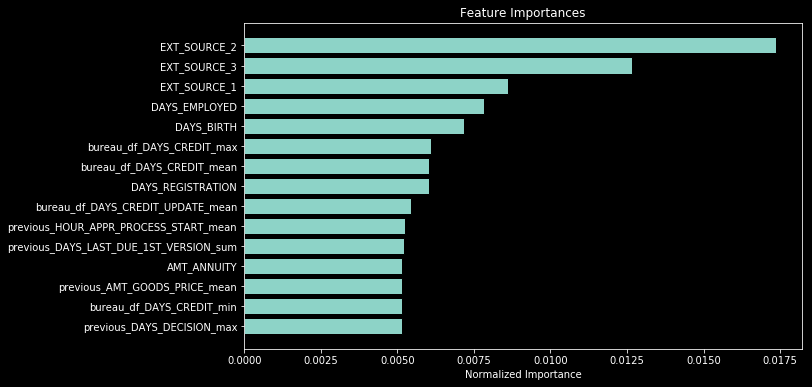

In [80]:
from sklearn.ensemble import RandomForestClassifier

param_grid_random = {'n_estimators': [100]}
# Make the random forest classifier
random_forest = RandomForestClassifier(random_state = 42, verbose = 1, n_jobs = -1)
prediction_lgr = classification_model(app_df_no_ids[:30000:], train_labels[:30000:], test_set=app_test_df_no_ids, pipeline=pipeline ,params=param_grid_random, GridSearch=True, model=random_forest, plot_features_importances=True)

3. LGB model

In [62]:
import lightgbm as lgb

params_lgb = { 
              "learning_rate": [0.05],
              "reg_alpha": [0.1],
              "reg_lambda": [0.1],
              "subsample": [0.8],
                'class_weight': 'balanced'
}

Starting Fold number: 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's binary_logloss: 0.251102	valid_1's binary_logloss: 0.365383
[2000]	training's binary_logloss: 0.136005	valid_1's binary_logloss: 0.305936
[3000]	training's binary_logloss: 0.0738648	valid_1's binary_logloss: 0.285301
Early stopping, best iteration is:
[3518]	training's binary_logloss: 0.053273	valid_1's binary_logloss: 0.282967
Starting Fold number: 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's binary_logloss: 0.249401	valid_1's binary_logloss: 0.365796
[2000]	training's binary_logloss: 0.134996	valid_1's binary_logloss: 0.305475
[3000]	training's binary_logloss: 0.072698	valid_1's binary_logloss: 0.284324
Early stopping, best iteration is:
[3549]	training's binary_logloss: 0.0510172	valid_1's binary_logloss: 0.280557
Starting Fold number: 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's binary_logloss: 0.247193	

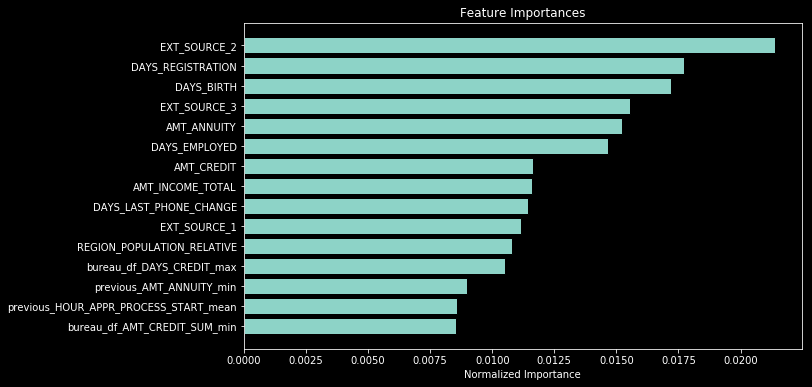

In [63]:
submission_prediction_LGB = classification_model(app_df_no_ids, train_labels, pipeline=pipeline ,params=params_lgb, GridSearch=False, plot_features_importances=True,test_set=app_test_df_no_ids)

In [74]:
submission_prediction_LGB = submission_prediction_LGB > 0.8 #as the prediction we got is an average across all the folds, we have a percentage for each target, I am gonna get only percentages greater than 80% here for target = 1

In [75]:
sub = pd.read_csv("../input/sample_submission.csv")
sub['TARGET'] = submission_prediction_LGB.astype('int8')
sub.to_csv('lgb_new_features.csv', index=False)

In [76]:
sub.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


In [77]:
sub["TARGET"].value_counts()

0    48168
1      576
Name: TARGET, dtype: int64